In [1]:
# Standard library imports
import csv
import json
import os
import time

# Third-party library imports
import ast
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Geospatial libraries
import geopandas as gpd

# PyTorch and related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Torchvision imports
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from torchvision.models import resnet18, resnet50
# For EfficientNet
from torchvision.models import (EfficientNet_B0_Weights,
                                efficientnet_b0)
# For ConvNeXt
from torchvision.models import (ConvNeXt_Tiny_Weights,
                                convnext_tiny)

# IPython widgets
import ipywidgets as widgets
from ipywidgets import interact

# Data Exploration

This code allows to explore data and by this verify the correctness and that it's there.

Selecting Country and Year allows to specify the path where the data is stored.

This part is not required to run for the training part.

In [2]:
# Interactive Widget to explore Satellite Image Data
# Which country and year to use
country = 'Senegal'
year = '2019'

# Load wealth index data
wealth_index_file = f'data/Results/LabelledGrids/{country}_{year}_wealthindex_labelled.gpkg'
wealth_index_gdf = gpd.read_file(wealth_index_file)
# Drop rows with missing wealth index
wealth_index_gdf = wealth_index_gdf.dropna(subset=['weighted_wealth'])
wealth_index_gdf = wealth_index_gdf.reset_index(drop=True)

# Construct list of filepaths for satellite images
satellite_images_filepaths = []
for cell_id in wealth_index_gdf['cell_id']:
    path = f'data/Results/SatelliteImageData/Images/Combined/{country}/{year}/cell_{cell_id}/combined_data.npz'
    satellite_images_filepaths.append(path)

# Function to plot satellite image data
def plot_satellite_data(index, filepaths, gdf):
    # Obtain data for the selected cell
    npz_file_path = filepaths[index]
    cell_id = gdf['cell_id'][index]
    wealth_index = gdf['weighted_wealth'][index]

    # Load satellite image data from .npz file
    data = np.load(npz_file_path)
    
    # Plot the data
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(f'Satellite Image Data for Cell {cell_id} (Wealth Index: {wealth_index})', fontsize=
                 16)
    
    # Plot color maps
    plots = [
        ('sentinel_rgb', 'RGB', None),
        ('sentinel_ndvi', 'NDVI', 'RdYlGn'),
        ('sentinel_built_up', 'Built-up', 'gray'),
        ('sentinel_nir', 'NIR', 'inferno'),
        ('sentinel_swir1', 'SWIR1', 'inferno'),
        ('sentinel_swir2', 'SWIR2', 'inferno'),
        ('viirs_nightlights', 'Nightlights', 'viridis'),
        ('viirs_gradient', 'Gradient', 'viridis')
    ]
    
    # Plot each image
    for ax, (key, title, cmap) in zip(axs, plots):
        im = ax.imshow(data[key], cmap=cmap)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
# Create widget with index slider
@interact(index=widgets.IntSlider(min=0, max=len(satellite_images_filepaths)-1, step=1, value=0))
def plot_satellite_data_widget(index=0):
    plot_satellite_data(index, satellite_images_filepaths, wealth_index_gdf)

interactive(children=(IntSlider(value=0, description='index', max=518), Output()), _dom_classes=('widget-inter…

# Dataset and Transforms

The code below defines a custom PyTorch dataset (`WealthDataset`) that loads `.npz` files containing various satellite channels (e.g., RGB, NDVI, SWIR). By specifying which channel keys to use (for example, `['sentinel_rgb', 'sentinel_ndvi']`), the dataset will stack the corresponding arrays into a single tensor.

- **`WealthDataset`**:  
  - Takes a list of `.npz` file paths and a matching list of wealth index targets.  
  - Gathers only the requested channels into a single multi‐channel array.  
  - Converts each array to `float32`, optionally transforms it, and returns both the sample and target.

- **`ToTensor`**:  
  - Converts an `(H, W, C)` NumPy array to a PyTorch tensor of shape `(C, H, W)`.

- **`MinMaxScale`**:  
  - Scales each channel from `[min_val, max_val]` to `[0, 1]`, defaulting to `[0, 255]`.

Finally, we compose these transforms into a pipeline with `torchvision.transforms.Compose`, preparing the dataset for model training.

In [4]:
# A dictionary mapping each channel key to its [min, max].
CHANNEL_RANGES = {
    "sentinel_rgb":       (0, 255),    # 3 sub-channels: R, G, B
    "sentinel_ndvi":      (0, 255),
    "sentinel_built_up":  (0, 255),
    "sentinel_nir":       (0, 65535),
    "sentinel_swir1":     (0, 65535),
    "sentinel_swir2":     (0, 65535),
    "viirs_nightlights":  (0, 65535),
    "viirs_gradient":     (0, 65535),
}

class WealthDataset(Dataset):
    """
    Loads NPZ files that contain multiple satellite channels.
    Each NPZ file is expected to contain one or more keys, e.g., 'sentinel_rgb', 'sentinel_ndvi', etc.
    
    Arguments:
        npz_filepaths: list of .npz file paths
        targets: list/array of float values (wealth indices)
        channels_to_use: list of channel keys, e.g. ['sentinel_rgb','sentinel_ndvi']
        transform: optional transforms (e.g., data augmentation and ToTensor)
    """
    def __init__(self, npz_filepaths, targets, channels_to_use, transform=None):
        super().__init__()
        self.npz_filepaths = npz_filepaths
        self.targets = targets
        self.channels_to_use = channels_to_use
        self.transform = transform

    def __len__(self):
        return len(self.npz_filepaths)

    def __getitem__(self, idx):
        file_path = self.npz_filepaths[idx]
        data = np.load(file_path)

        # Collect and scale channel arrays.
        arrays = []
        for ch in self.channels_to_use:
            arr = data[ch]  # shape could be (H,W) or (H,W,3)
            if arr.ndim == 2:
                arr = arr[..., None]  # Convert (H,W) to (H,W,1)
            ch_min, ch_max = CHANNEL_RANGES[ch]
            arr = (arr - ch_min) / (ch_max - ch_min + 1e-8)
            arrays.append(arr.astype(np.float32))
        # Concatenate along the last axis: (H, W, total_channels)
        combined = np.concatenate(arrays, axis=-1)

        # Retrieve target.
        target = np.float32(self.targets[idx])

        # Apply augmentations and other transforms.
        if self.transform:
            combined = self.transform(combined)

        return combined, target

class RandomFlipAndRotate:
    """
    Applies random horizontal flip, vertical flip, and a random 90-degree rotation.
    This augmentation is applied to the numpy array before converting to a tensor.
    """
    def __init__(self, horizontal_flip=True, vertical_flip=True, rotation=True, p=0.5):
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rotation = rotation
        self.p = p

    def __call__(self, sample):
        # sample is a numpy array of shape (H, W, C)
        if self.horizontal_flip and random.random() < self.p:
            sample = np.flip(sample, axis=1)  # Flip columns.
        if self.vertical_flip and random.random() < self.p:
            sample = np.flip(sample, axis=0)  # Flip rows.
        if self.rotation and random.random() < self.p:
            k = random.randint(0, 3)  # Rotate by 0, 90, 180, or 270 degrees.
            sample = np.rot90(sample, k)
        # Convert to a contiguous array to avoid negative strides.
        return np.ascontiguousarray(sample)

class ToTensor:
    """Converts a (H, W, C) numpy array to a torch.FloatTensor of shape (C, H, W)."""
    def __call__(self, sample):
        return torch.from_numpy(sample).permute(2, 0, 1)

transform = T.Compose([
    RandomFlipAndRotate(p=0.5),
    ToTensor()
])

# Model Definition

This code provides a flexible CNN‐based regression model that can handle various backbones (ResNet, EfficientNet, ConvNeXt) and a customizable MLP head. It allows multi‐channel input (e.g., 4 channels for RGB+NIR) by modifying the first convolution layer. 

- **`create_mlp`**:  
  Builds a simple feed‐forward network of one or more hidden layers (with optional dropout), ending in a single regression output (for predicting wealth index).

- **`ResNetRegressor`**:  
  1. Loads and configures the specified backbone (e.g., ResNet, EfficientNet, ConvNeXt).  
  2. Replaces the first convolution to accommodate `num_in_channels` > 3 (for satellite data like RGB + NDVI).  
  3. Replaces the backbone’s default classifier with an identity or partial identity, so we can attach a custom MLP.  
  4. Adds the MLP head, mapping the final feature dimension to a single scalar.  
  5. In `forward()`, the images pass through the backbone, then through the MLP to produce a single wealth prediction.

- **`parse_country_code_and_year`**:  
  A small helper function that interprets two‐letter codes (e.g., `"sg"`) as full country names (e.g., `"Senegal"`) and extracts the year from the remaining string.

Nothing to set or configure here, just defining the model and helper functions.

In [5]:
def create_mlp(input_dim, layer_dims, dropout=0.2):
    """
    Creates an MLP block given a list of hidden layer sizes.
    Hidden layers are initialized with standard Xavier uniform initialization.
    The final linear layer is initialized with a smaller gain (e.g., 0.1)
    to prevent extreme logit values before applying the Hardtanh.
    The final Hardtanh constrains the output between 0 and 1.
    """
    layers = []
    prev_dim = input_dim
    # Build hidden layers.
    for dim in layer_dims:
        linear_layer = nn.Linear(prev_dim, dim)
        # Standard Xavier initialization for hidden layers.
        nn.init.xavier_uniform_(linear_layer.weight)
        if linear_layer.bias is not None:
            nn.init.constant_(linear_layer.bias, 0)
        layers.append(linear_layer)
        layers.append(nn.ReLU())
        if dropout > 0:
            layers.append(nn.Dropout(p=dropout))
        prev_dim = dim

    # Create and initialize the final linear layer with a lower gain.
    final_linear = nn.Linear(prev_dim, 1)
    nn.init.xavier_uniform_(final_linear.weight, gain=0.1)
    if final_linear.bias is not None:
        nn.init.constant_(final_linear.bias, 0)
    layers.append(final_linear)
    # Use Hardtanh to constrain output between 0 and 1.
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers)

class ResNetRegressor(nn.Module):
    def __init__(self, 
                 num_in_channels=4,       
                 backbone='resnet18', 
                 pretrained=True,
                 mlp_layers=[256],
                 dropout=0.2):
        super().__init__()

        # Load the backbone
        if backbone == 'resnet18':
            if pretrained:
                self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            else:
                self.backbone = resnet18(weights=None)
            num_features = 512

        elif backbone == 'resnet50':
            if pretrained:
                self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            else:
                self.backbone = resnet50(weights=None)
            num_features = 2048

        elif backbone == 'efficientnet_b0':
            if pretrained:
                self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
            else:
                self.backbone = efficientnet_b0(weights=None)
            num_features = 1280

        elif backbone == 'convnext_tiny':
            if pretrained:
                self.backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
            else:
                self.backbone = convnext_tiny(weights=None)
            num_features = 768

        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Replace first conv layer for multi-channel input.
        self._replace_first_conv(num_in_channels, backbone)

        # Replace final classifier
        if backbone.startswith('resnet'):
            self.backbone.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            self.backbone.classifier = nn.Identity()
        elif backbone == 'convnext_tiny':
            # Partial replacement: keep LN+Flatten, remove final linear
            self.backbone.classifier[2] = nn.Identity()

        # Create the MLP head.
        self.mlp = create_mlp(num_features, mlp_layers, dropout)

    def _replace_first_conv(self, num_in_channels, backbone):
        """
        Replaces the first convolution with one that accepts `num_in_channels` instead of 3.
        Copies the first 3 channels' weights; xavier-inits the rest.
        """
        if backbone in ['resnet18', 'resnet50']:
            old_conv = self.backbone.conv1
            old_weights = old_conv.weight.data
            new_conv = nn.Conv2d(
                in_channels=num_in_channels,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            copy_ch = min(3, num_in_channels)
            new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
            if num_in_channels > 3:
                nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
            self.backbone.conv1 = new_conv

        elif backbone == 'efficientnet_b0':
            old_conv = self.backbone.features[0][0]
            old_weights = old_conv.weight.data
            new_conv = nn.Conv2d(
                in_channels=num_in_channels,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            copy_ch = min(3, num_in_channels)
            new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
            if num_in_channels > 3:
                nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
            self.backbone.features[0][0] = new_conv

        elif backbone == 'convnext_tiny':
            old_conv = self.backbone.features[0][0]
            old_weights = old_conv.weight.data
            new_conv = nn.Conv2d(
                in_channels=num_in_channels,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            copy_ch = min(3, num_in_channels)
            new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
            if num_in_channels > 3:
                nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
            self.backbone.features[0][0] = new_conv

        else:
            raise ValueError(f"Unhandled backbone: {backbone}")

    def forward(self, x):
        features = self.backbone(x)
        return self.mlp(features)

def parse_country_code_and_year(code):
    """
    e.g. 'sg2019' => ('Senegal', '2019').
    """
    code_map = {
        'sg': 'Senegal',
        'gh': 'Ghana',
    }
    prefix = code[:2]
    year_str = code[2:]
    
    country = code_map.get(prefix, None)
    if country is None:
        raise ValueError(f"Unknown country code '{prefix}'. Please add it to code_map.")
    
    return country, year_str

# Training Function

The code below provides a **single function** (`train_regression_model`) for training a regression CNN on multiple country-year datasets. It automatically logs each run's hyperparameters and performance metrics to a CSV, potentially saving the trained model as well.

- **Overview**:
  - **Data Accumulation**: Merges `.npz` file paths and corresponding wealth targets from one or more country-year inputs (e.g. `['sg2019', 'sg2018']`).  
  - **Dataset & DataLoader**: Creates `WealthDataset` instances for train and test, splitting them using a given `test_size`.  
  - **Dynamic Channel Counting**: Determines how many channels (`num_in_channels`) to expect by examining the first `.npz` sample.  
  - **Model**: Builds a `ResNetRegressor` (optionally using EfficientNet or ConvNeXt, etc.) with a specified MLP head.  
  - **Training Loop**:  
    - Runs for `num_epochs`, tracking the mean squared error (MSE) loss for both training and testing each epoch.  
    - Keeps track of the **best** (lowest) test loss and its epoch.  
  - **Plotting**: If `plot_losses=True`, shows a basic line plot comparing train vs. test losses over epochs.  
  - **Saving Model & Logging**:  
    - If `model_name` is set, saves the trained model’s state to `data/Results/Models/{model_name}.pth`.  
    - Appends a row to a log CSV (`results_csv`), recording hyperparameters, train/test loss progressions, best epoch, etc.

The user does **not** need to change anything — simply **run** this function (with their chosen parameters) to perform training, automatically store run information, and optionally save the trained model.

In [6]:
def train_regression_model(
    country_year_list,         # e.g. ['sg2019', 'sg2018']
    channels_to_use,           # e.g. ['sentinel_rgb','sentinel_ndvi']
    model_name=None,           # If None, do NOT save model. If string, save to file.
    backbone="resnet18",       # 'resnet18', 'resnet50', 'efficientnet_b0', 'convnext_tiny'
    pretrained=True,
    mlp_layers=[256],
    dropout=0.2,
    lr=1e-4,
    batch_size=8,
    num_epochs=5,
    test_size=0.2,
    random_state=42,
    results_csv="big_results.csv",
    plot_losses=False,
    device=None,
    freeze_cnn=False,         # set to True to freeze the CNN backbone.
    weight_decay=1e-5         # Weight decay for L2 regularization.
):
    """
    Loads data from multiple country-year combos, trains a regression model, and appends results to 'results_csv'.

    If model_name is None, no model is saved;
    if model_name is a string, the trained model is saved to 
    'data/Results/Models/{model_name}.pth'.

    Returns a dict with final training info.
    """

    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() 
                              else "cuda" if torch.cuda.is_available() 
                              else "cpu")
        print(f"Using device: {device}")

    # Accumulate NPZ file paths & targets from all country-year combos.
    all_filepaths = []
    all_targets = []

    for code in country_year_list:
        ctry, yr = parse_country_code_and_year(code)
        wealth_index_file = f"data/Results/LabelledGrids/{ctry}_{yr}_wealthindex_labelled.gpkg"
        
        # Load GPKG and drop NA rows.
        wealth_index_gdf = gpd.read_file(wealth_index_file)
        wealth_index_gdf = wealth_index_gdf.dropna(subset=['weighted_wealth']).reset_index(drop=True)
        
        # Build NPZ file paths.
        for cell_id in wealth_index_gdf['cell_id']:
            path = f"data/Results/SatelliteImageData/Images/Combined/{ctry}/{yr}/cell_{cell_id}/combined_data.npz"
            all_filepaths.append(path)
        
        these_targets = wealth_index_gdf['weighted_wealth'].values
        all_targets.extend(these_targets)

    all_targets = np.array(all_targets, dtype=np.float32)
    n_total_data = len(all_targets)
    if n_total_data == 0:
        raise ValueError("No valid data was found across all provided country-year combos!")

    # Train/Test Split.
    train_paths, test_paths, train_targets, test_targets = train_test_split(
        all_filepaths, all_targets,
        test_size=test_size,
        random_state=random_state
    )

    # Create Datasets.
    # Ensure your WealthDataset and transform are defined/imported appropriately.
    train_dataset = WealthDataset(train_paths, train_targets, channels_to_use, transform=transform)
    test_dataset  = WealthDataset(test_paths,  test_targets,  channels_to_use, transform=transform)

    # Print out number of samples in each set.
    print(f"Training samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")
    

    # DataLoaders.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # Count input channels from one sample.
    example_data = np.load(train_paths[0])
    num_in_channels = 0
    for ch in channels_to_use:
        arr = example_data[ch]
        c = arr.shape[-1] if arr.ndim == 3 else 1
        num_in_channels += c

    # Build the model.
    model = ResNetRegressor(
        num_in_channels=num_in_channels,
        backbone=backbone,
        pretrained=pretrained,
        mlp_layers=mlp_layers,
        dropout=dropout
    ).to(device)

    # Optionally freeze the CNN backbone.
    if freeze_cnn:
        for param in model.backbone.parameters():
            param.requires_grad = False

    # Set up training: loss and optimizer.
    # The optimizer only updates parameters that are trainable.
    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_epoch = -1

    for epoch in range(1, num_epochs+1):
        start_time = time.time()
        model.train()
        running_train_loss = 0.0
        for images, targets_batch in train_loader:
            images = images.to(device)
            targets_batch = targets_batch.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for images, targets_batch in test_loader:
                images = images.to(device)
                targets_batch = targets_batch.to(device).view(-1, 1)

                outputs = model(images)
                loss = criterion(outputs, targets_batch)
                running_test_loss += loss.item() * images.size(0)

        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            best_epoch = epoch

        sqrt_test_loss = np.sqrt(epoch_test_loss)
        wealth_index_lower_bound = 0
        wealth_index_upper_bound = 1
        wealth_index_range = wealth_index_upper_bound - wealth_index_lower_bound
        sqrt_test_loss_percentage_deviation = (sqrt_test_loss - wealth_index_lower_bound) / wealth_index_range

        duration_epoch = time.time() - start_time
        minutes_epoch = round(duration_epoch / 60, 2)
        print(f"[{epoch}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Avg Test Dev in perc: {100*sqrt_test_loss_percentage_deviation:.2f}% | Duration: {minutes_epoch} mins")

    if plot_losses:
        plt.figure()
        plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title(f"Train vs Test Loss, Model={model_name})")
        plt.grid(axis='y')
        plt.legend()
        plt.show()

    if model_name is not None:
        os.makedirs("data/Results/Models", exist_ok=True)
        model_path = os.path.join("data/Results/Models", f"{model_name}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to: {model_path}")

    file_exists = os.path.isfile(results_csv)
    header = [
        "timestamp",
        "country_year_list",
        "n_total_data",
        "channels_to_use",
        "backbone",
        "pretrained",
        "mlp_layers",
        "dropout",
        "lr",
        "batch_size",
        "freeze_cnn",
        "weight_decay",
        "num_epochs",
        "test_size",
        "random_state",
        "train_loss_progression",
        "test_loss_progression",
        "best_epoch",
        "best_test_loss",
        "model_name"
    ]

    train_loss_str = json.dumps(train_losses)
    test_loss_str = json.dumps(test_losses)
    row_data = [
        time.strftime("%Y-%m-%d %H:%M:%S"),
        str(country_year_list),
        n_total_data,
        str(channels_to_use),
        backbone,
        pretrained,
        str(mlp_layers),
        dropout,
        lr,
        batch_size,
        freeze_cnn,
        weight_decay,
        num_epochs,
        test_size,
        random_state,
        train_loss_str,
        test_loss_str,
        best_epoch,
        best_test_loss,
        model_name if model_name is not None else ""
    ]

    with open(results_csv, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(header)
        writer.writerow(row_data)

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "best_test_loss": best_test_loss,
        "best_epoch": best_epoch,
        "n_total_data": n_total_data
    }

# Single Training Runs

In this snippet, you can **experiment** with individual training runs by adjusting key hyperparameters like which satellite channels to include, the neural network backbone, and training details (epochs, learning rate, etc.). Here, we define:

- **`all_channels`**: A list of all available channels (RGB, NDVI, SWIR, nightlights, etc.).  
- **`country_year_list`**: Which country-year datasets to load (e.g., `["sg2019"]`).  
- **`channels_to_use`**: You can swap between all channels or a subset.  
- **`model_name`**: If set to `None`, no `.pth` file is saved; otherwise, the trained model is saved for later use.  
- **Backbone & Hyperparams**: Change `backbone`, `pretrained`, `mlp_layers`, `dropout`, and so on to see how performance shifts.

Finally, we call `train_regression_model(...)`, which automatically handles data loading, training, logging to CSV, and optional plotting of the train/test loss curves. This block is perfect for **playing around** with different configurations and quickly checking how they affect your model’s performance on a single run.

Using device: mps
Training samples: 2573 | Test samples: 644
[1/25] Train Loss: 0.0089 | Test Loss: 0.0067 | Avg Test Dev in perc: 8.16% | Duration: 1.02 mins
[2/25] Train Loss: 0.0053 | Test Loss: 0.0052 | Avg Test Dev in perc: 7.21% | Duration: 1.0 mins
[3/25] Train Loss: 0.0040 | Test Loss: 0.0044 | Avg Test Dev in perc: 6.67% | Duration: 1.01 mins
[4/25] Train Loss: 0.0035 | Test Loss: 0.0043 | Avg Test Dev in perc: 6.53% | Duration: 1.0 mins
[5/25] Train Loss: 0.0029 | Test Loss: 0.0045 | Avg Test Dev in perc: 6.72% | Duration: 1.01 mins
[6/25] Train Loss: 0.0029 | Test Loss: 0.0042 | Avg Test Dev in perc: 6.44% | Duration: 1.01 mins
[7/25] Train Loss: 0.0026 | Test Loss: 0.0042 | Avg Test Dev in perc: 6.46% | Duration: 1.02 mins
[8/25] Train Loss: 0.0023 | Test Loss: 0.0040 | Avg Test Dev in perc: 6.35% | Duration: 1.02 mins
[9/25] Train Loss: 0.0023 | Test Loss: 0.0043 | Avg Test Dev in perc: 6.57% | Duration: 1.02 mins
[10/25] Train Loss: 0.0020 | Test Loss: 0.0041 | Avg Test D

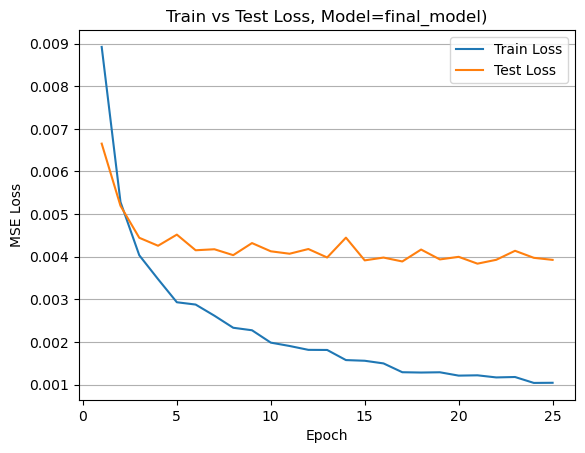

Model saved to: data/Results/Models/final_model.pth
Training finished with best test loss: 0.0038


In [9]:
all_channels = [
    "sentinel_rgb",       # shape: (256,256,3)
    "sentinel_ndvi",      # shape: (256,256)
    "sentinel_built_up",
    "sentinel_nir",
    "sentinel_swir1",
    "sentinel_swir2",
    "viirs_nightlights",
    "viirs_gradient"
]

# Configure the Training Run
country_year_list = ["sg2016", "sg2017", "sg2018", "sg2019", "sg2023"]
channels_to_use = ["sentinel_rgb", "sentinel_ndvi", "sentinel_swir1", "sentinel_nir", "viirs_nightlights"]
#channels_to_use = ["sentinel_rgb"]
model_name = "final_model" # If None, do NOT save model. If string, save to file.
backbone = "efficientnet_b0" # "resnet18" or "resnet50" or "efficientnet_b0" or "convnext_tiny"
pretrained = True # Use pre-trained weights?
mlp_layers = [64, 32] # MLP hidden layer sizes
dropout = 0.05 # Dropout rate
lr = 0.0001
batch_size = 64
num_epochs = 25
test_size = 0.2
random_state = 42
freeze_cnn = False
weight_decay = 0.00001 # 0.01, 0.001, 0.0001 (larger => more regularization)


results = train_regression_model(
    country_year_list=country_year_list,
    channels_to_use=channels_to_use,
    model_name=model_name,
    backbone=backbone,
    pretrained=pretrained,
    mlp_layers=mlp_layers,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    num_epochs=num_epochs,
    test_size=test_size,
    random_state=random_state,
    results_csv="data/Results/Models/TrainingResultsLog.csv",
    plot_losses=True,
    freeze_cnn=freeze_cnn,         # Set this to True to freeze the CNN backbone.
    weight_decay=weight_decay         # L2 regularization coefficient.
)

print(f'Training finished with best test loss: {results["best_test_loss"]:.4f}')

# Hyperparameter Grid Search

This code systematically explores multiple **hyperparameter combinations** (country-year inputs, channel subsets, backbone architectures, learning rates, etc.) by iterating over the Cartesian product of parameter lists. For each unique combination, it calls the same `train_regression_model(...)` function used for single runs, logging results to a central CSV.

Key points:

- **`country_year_lists`** and **`channels_to_use_options`**: Different sets of data (e.g., `["sg2019"]` or multiple years) and different channel subsets (RGB, NDVI, etc.).  
- **`backbones`, `pretrained_options`, `mlp_layers_options`**: Vary the CNN architecture (ResNet, EfficientNet, ConvNeXt) and MLP configuration (hidden layers, dropout, etc.).  
- **Other Parameters**: `dropouts`, `lrs` (learning rates), `batch_sizes`, and `num_epochs_list` each define possible values to try.  
- **`run_grid_search()`**:  
  1. Builds all combinations with `itertools.product(...)`.  
  2. Loops through each combo, constructing a descriptive `model_name` and calling `train_regression_model`.  
  3. Each run appends a row to the same **`results_csv`** with final training metrics.  
  4. Prints a summary after each run, plus a final message indicating completion.

By adjusting these lists, you can **expand** or **reduce** the search space. This approach automates multiple experiments, helping you find which hyperparameters (e.g., backbone, dropout, or channel selection) yield the best performance.

In [7]:
import itertools
# Possible country-year combos. Each entry is itself a list,
# e.g. ["sg2019"] or ["sg2018", "sg2019"]
country_year_lists = [
    ["sg2016", "sg2017", "sg2018", "sg2019", "sg2023"]
]

# Possible channel combos. Each entry is a list of channel keys.
channels_to_use_options = [
    [
        "sentinel_rgb",       # shape: (256,256,3)
        "sentinel_ndvi",      # shape: (256,256)
        "sentinel_built_up",
        "sentinel_nir",
        "sentinel_swir1",
        "viirs_nightlights"
    ]
]

backbones = [
    "efficientnet_b0",
] # "resnet18" or "resnet50" or "efficientnet_b0" or "convnext_tiny"
pretrained_options = [True]
mlp_layers_options = [
    [64, 32]
]
dropouts = [0.05]
lrs = [0.005, 0.001, 0.0005, 0.0001]  # learning rates
batch_sizes = [64]               # batch size (number of samples per training batch)
num_epochs_list = [25]
test_size = 0.2
random_state = 42
freeze_cnn_options = [False]
weight_decay_options = [0.00001]  # L2 regularization coefficient

results_csv = "data/Results/Models/TrainingResultsLog.csv"

def run_grid_search():
    """
    Iterates over all combinations of hyperparameters (including the new freeze_cnn
    and weight_decay parameters). Calls train_regression_model(...) for each combo,
    which appends the run's results to the specified CSV.
    """
    all_combinations = list(itertools.product(
        country_year_lists,
        channels_to_use_options,
        backbones,
        pretrained_options,
        mlp_layers_options,
        dropouts,
        lrs,
        batch_sizes,
        num_epochs_list,
        freeze_cnn_options,
        weight_decay_options
    ))

    print(f"Total hyperparameter combinations: {len(all_combinations)}\n")

    combo_id = 0
    for (
        cy_list,
        channels,
        backbone,
        pretrained,
        mlp_layers,
        dropout,
        lr,
        batch_size,
        num_epochs,
        freeze_cnn,
        weight_decay
    ) in all_combinations:
        combo_id += 1

        # Build a model name string that incorporates all hyperparameters.
        model_name = (f"{'-'.join(cy_list)}_"
                      f"{'-'.join(channels)}_"
                      f"{backbone}_pt{int(pretrained)}_mlp{mlp_layers}_"
                      f"do{dropout}_lr{lr}_bs{batch_size}_ep{num_epochs}_"
                      f"freeze{int(freeze_cnn)}_wd{weight_decay}")

        print(f"=== Combination {combo_id}/{len(all_combinations)} ===")
        print(f"  country_year_list={cy_list}")
        print(f"  channels_to_use={channels}")
        print(f"  backbone={backbone}, pretrained={pretrained}")
        print(f"  mlp_layers={mlp_layers}, dropout={dropout}")
        print(f"  lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}")
        print(f"  freeze_cnn={freeze_cnn}, weight_decay={weight_decay}")
        print(f"  model_name={model_name}")
        print("--------------------------------------------------")

        results = train_regression_model(
            country_year_list=cy_list,
            channels_to_use=channels,
            model_name=None,  # Don't save model during grid search.
            backbone=backbone,
            pretrained=pretrained,
            mlp_layers=mlp_layers,
            dropout=dropout,
            lr=lr,
            batch_size=batch_size,
            num_epochs=num_epochs,
            test_size=test_size,
            random_state=random_state,
            results_csv=results_csv,   # All runs append to the same CSV.
            plot_losses=False,         # Typically false for big grids.
            freeze_cnn=freeze_cnn,       # New parameter.
            weight_decay=weight_decay    # New parameter.
        )

        print(f"Finished run with best test loss: {results['best_test_loss']:.4f}\n")

    print("All grid search runs complete! Logged to:", results_csv)

run_grid_search()

Total hyperparameter combinations: 4

=== Combination 1/4 ===
  country_year_list=['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg2023']
  channels_to_use=['sentinel_rgb', 'sentinel_ndvi', 'sentinel_built_up', 'sentinel_nir', 'sentinel_swir1', 'viirs_nightlights']
  backbone=efficientnet_b0, pretrained=True
  mlp_layers=[64, 32], dropout=0.05
  lr=0.005, batch_size=64, num_epochs=25
  freeze_cnn=False, weight_decay=1e-05
  model_name=sg2016-sg2017-sg2018-sg2019-sg2023_sentinel_rgb-sentinel_ndvi-sentinel_built_up-sentinel_nir-sentinel_swir1-viirs_nightlights_efficientnet_b0_pt1_mlp[64, 32]_do0.05_lr0.005_bs64_ep25_freeze0_wd1e-05
--------------------------------------------------
Using device: mps
Training samples: 2573 | Test samples: 644
[1/25] Train Loss: 0.0070 | Test Loss: 0.0062 | Avg Test Dev in perc: 7.87% | Duration: 1.11 mins
[2/25] Train Loss: 0.0051 | Test Loss: 0.0092 | Avg Test Dev in perc: 9.58% | Duration: 1.09 mins
[3/25] Train Loss: 0.0052 | Test Loss: 0.0079 | Avg Test De

# Results Inspection and Metrics Analysis

This code demonstrates how to **parse** the logged experiment results from a CSV, then **compute** additional metrics to evaluate each training run’s behavior:

1. **Load & Parse** the CSV into a DataFrame (`results_df`), converting certain columns (like `channels_to_use`, `train_loss_progression`) from strings to actual lists.

2. **Compute Metrics** with `compute_run_metrics`:  
   - **Train Improvement**: Measures how much the training loss decreased.  
   - **Test Improvement**: Measures how much the test loss improved across epochs.  
   - **Test Volatility**: Standard deviation of the test loss (large values indicate unstable runs).  
   - **Overfit Gap**: The difference between the final test loss and the final train loss.  
   - **Convergence Score**: A simple combined metric that **rewards** improvement and **penalizes** volatility and overfitting.

3. **Combine** these metrics with the original DataFrame, then **sort** runs by either `convergence_score` or the best test loss.

4. **Visualize** your results:  
   - Print the top runs for each sorting criterion.  
   - Optionally **plot** one hyperparameter (e.g. `backbone`) against a chosen metric (e.g. `best_test_loss`), using a scatter plot to see which configurations stand out.

By adjusting parameters like **`target_metric`** or exploring different hyperparameters in the scatter plot, you can quickly identify which runs converge nicely, which are overfitting, and which produce the best overall performance.

In [10]:
# load results csv file
results_df = pd.read_csv("data/Results/Models/TrainingResultsLog.csv")
# Parse columns that store lists as strings, so we can handle them as Python lists
parse_cols = ["train_loss_progression", "test_loss_progression"]
for col in parse_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else None)


# keep only the last 20 rows
#results_df = results_df.iloc[-30:].copy().reset_index(drop=True)
results_df

,timestamp,country_year_list,n_total_data,channels_to_use,backbone,pretrained,mlp_layers,dropout,lr,batch_size,freeze_cnn,weight_decay,num_epochs,test_size,random_state,train_loss_progression,test_loss_progression,best_epoch,best_test_loss,model_name
0,2025-03-17 18:49:32,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,16,False,0.00000,10,0.2,42,"[0.06077753492396012, 0.023832271274214036, 0....","[0.016034105903844336, 0.011639260047518495, 0...",9,0.005761,NaN
1,2025-03-17 19:02:20,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,16,False,0.00000,25,0.2,42,"[0.058214006210877516, 0.02524844969962245, 0....","[0.01594370614681671, 0.010555970830036633, 0....",21,0.005029,NaN
2,2025-03-17 19:12:48,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00010,8,False,0.00000,10,0.2,42,"[0.04172830997713815, 0.014898162557978496, 0....","[0.018772593810598353, 0.00782833131614016, 0....",7,0.005425,NaN
3,2025-03-17 19:18:29,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,8,False,0.00000,10,0.2,42,"[0.030703679446096175, 0.014208153710987801, 0...","[0.01340357362251006, 0.00916867488439181, 0.0...",9,0.005327,NaN
4,2025-03-17 19:23:21,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,False,[128],0.20,0.00010,8,False,0.00000,10,0.2,42,"[0.02715527050406019, 0.00951508232697009, 0.0...","[0.008628429879726314, 0.007567221305763989, 0...",5,0.005005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2025-03-21 13:28:24,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00500,64,False,0.00001,25,0.2,42,"[0.006986232793513863, 0.005067186687992986, 0...","[0.006191007497934451, 0.009170838834150978, 0...",10,0.004838,NaN
155,2025-03-21 13:59:38,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00100,64,False,0.00001,25,0.2,42,"[0.005913007004693978, 0.003968425240770151, 0...","[0.004924304368659877, 0.004723541936056214, 0...",20,0.003859,NaN
156,2025-03-21 14:31:19,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00050,64,False,0.00001,25,0.2,42,"[0.006288507375779304, 0.003896360757756722, 0...","[0.0065962446055242, 0.004536079692579111, 0.0...",17,0.003700,NaN
157,2025-03-21 15:03:40,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00010,64,False,0.00001,25,0.2,42,"[0.009521700042957607, 0.0057051988141926125, ...","[0.007230551612580785, 0.0052900940023640295, ...",9,0.003638,NaN


In [11]:
# Helper to compute scores for each run
def compute_run_metrics(row):
    """
    Returns a dict of additional metrics:
      - train_improvement: fraction drop from train_loss[0] to train_loss[-1]
      - test_improvement: fraction drop from test_loss[0] to test_loss[-1]
      - test_volatility: standard deviation of test losses across epochs
      - overfit_gap: final test loss - final train loss
      - convergence_score: a simplistic combination that rewards improvement and punishes volatility, etc.
    """
    # Access train/test lists
    train_losses = row["train_loss_progression"]
    test_losses  = row["test_loss_progression"]
    
    # If missing data, return defaults
    if not train_losses or not test_losses:
        print("Missing data")
        return {
            "train_improvement": np.nan,
            "test_improvement":  np.nan,
            "test_volatility":   np.nan,
            "overfit_gap":       np.nan,
            "convergence_score": np.nan
        }
    
    # Make sure they have at least 2 epochs
    if len(train_losses) < 2 or len(test_losses) < 2:
        print("Not enough epochs")
        return {
            "train_improvement": np.nan,
            "test_improvement":  np.nan,
            "test_volatility":   np.nan,
            "overfit_gap":       np.nan,
            "convergence_score": np.nan
        }
    
    # 1) Train improvement
    initial_train = train_losses[0]
    final_train   = train_losses[-1]
    train_improvement = (initial_train - final_train) / (initial_train + 1e-8)
    
    # 2) Test improvement
    initial_test = test_losses[0]
    final_test   = test_losses[-1]
    test_improvement = (initial_test - final_test) / (initial_test + 1e-8)
    
    # 3) Volatility in test loss => standard deviation
    test_volatility = np.std(test_losses)
    
    # 4) Overfitting gap => final_test_loss - final_train_loss
    overfit_gap = final_test - final_train
    
    # 5) A simple "convergence_score" that tries to combine these:
    #    - Reward big test improvement
    #    - Penalize big test volatility
    #    - Also penalize large overfit gap
    #    This is arbitrary; you can define your own weighting.
    #    We'll do: 
    #        score = test_improvement - 2 * test_volatility - 1 * overfit_gap
    #    so a run with strong improvement, low volatility, and low overfitting is good.
    convergence_score = test_improvement - 2.0*test_volatility - overfit_gap
    
    return_dict =  {
        "train_improvement": train_improvement,
        "test_improvement": test_improvement,
        "test_volatility": test_volatility,
        "overfit_gap": overfit_gap,
        "convergence_score": convergence_score
    }
    return return_dict
    
# Apply the helper to each row => new columns
metrics = results_df.apply(compute_run_metrics, axis=1)
metrics_df = pd.DataFrame(metrics.tolist())
# Merge with original DataFrame
df = pd.concat([results_df, metrics_df], axis=1)
df

,timestamp,country_year_list,n_total_data,channels_to_use,backbone,pretrained,mlp_layers,dropout,lr,batch_size,...,train_loss_progression,test_loss_progression,best_epoch,best_test_loss,model_name,train_improvement,test_improvement,test_volatility,overfit_gap,convergence_score
0,2025-03-17 18:49:32,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,16,...,"[0.06077753492396012, 0.023832271274214036, 0....","[0.016034105903844336, 0.011639260047518495, 0...",9,0.005761,NaN,0.912373,0.614435,0.003022,0.000856,0.607535
1,2025-03-17 19:02:20,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,16,...,"[0.058214006210877516, 0.02524844969962245, 0....","[0.01594370614681671, 0.010555970830036633, 0....",21,0.005029,NaN,0.936772,0.632329,0.002359,0.002181,0.625430
2,2025-03-17 19:12:48,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00010,8,...,"[0.04172830997713815, 0.014898162557978496, 0....","[0.018772593810598353, 0.00782833131614016, 0....",7,0.005425,NaN,0.881474,0.619612,0.003781,0.002195,0.609855
3,2025-03-17 19:18:29,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,[128],0.20,0.00005,8,...,"[0.030703679446096175, 0.014208153710987801, 0...","[0.01340357362251006, 0.00916867488439181, 0.0...",9,0.005327,NaN,0.852796,0.585247,0.002294,0.001039,0.579618
4,2025-03-17 19:23:21,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,False,[128],0.20,0.00010,8,...,"[0.02715527050406019, 0.00951508232697009, 0.0...","[0.008628429879726314, 0.007567221305763989, 0...",5,0.005005,NaN,0.762129,-0.333739,0.001854,0.005049,-0.342496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2025-03-21 13:28:24,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00500,64,...,"[0.006986232793513863, 0.005067186687992986, 0...","[0.006191007497934451, 0.009170838834150978, 0...",10,0.004838,NaN,0.437143,0.117648,0.001283,0.001530,0.113551
155,2025-03-21 13:59:38,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00100,64,...,"[0.005913007004693978, 0.003968425240770151, 0...","[0.004924304368659877, 0.004723541936056214, 0...",20,0.003859,NaN,0.542824,0.099560,0.000359,0.001731,0.097111
156,2025-03-21 14:31:19,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00050,64,...,"[0.006288507375779304, 0.003896360757756722, 0...","[0.0065962446055242, 0.004536079692579111, 0.0...",17,0.003700,NaN,0.713143,0.380953,0.000532,0.002279,0.377610
157,2025-03-21 15:03:40,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.00010,64,...,"[0.009521700042957607, 0.0057051988141926125, ...","[0.007230551612580785, 0.0052900940023640295, ...",9,0.003638,NaN,0.892518,0.480591,0.000723,0.002732,0.476413


In [12]:
# Show top runs sorted by "convergence_score" or by "best_test_loss"
df_sorted = df.sort_values("convergence_score", ascending=False)
print("\n--- Top runs by 'convergence_score' (higher is better) ---\n")
df_sorted.head(5)


--- Top runs by 'convergence_score' (higher is better) ---



,timestamp,country_year_list,n_total_data,channels_to_use,backbone,pretrained,mlp_layers,dropout,lr,batch_size,...,train_loss_progression,test_loss_progression,best_epoch,best_test_loss,model_name,train_improvement,test_improvement,test_volatility,overfit_gap,convergence_score
24,2025-03-18 10:12:47,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet18,True,"[256, 128, 64]",0.2,0.0010,8,...,"[0.02270082110869829, 0.01305844949941351, 0.0...","[0.0760813112745979, 0.013856851885011836, 0.0...",7,0.005466,NaN,0.697331,0.884789,0.020543,0.001895,0.841809
27,2025-03-18 10:34:29,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet50,True,[128],0.2,0.0010,8,...,"[0.04784325219812655, 0.014533859590573288, 0....","[0.027627960250560028, 0.010279627092905454, 0...",10,0.004510,NaN,0.848040,0.836750,0.006218,-0.002760,0.827075
8,2025-03-17 19:56:28,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet50,False,[128],0.2,0.0001,8,...,"[0.03766528103396157, 0.01191136683903147, 0.0...","[0.04882969840693829, 0.015092983348434097, 0....",8,0.006133,NaN,0.689483,0.843141,0.023093,-0.004036,0.800992
66,2025-03-18 16:33:00,"['sg2019', 'sg2023']",1338,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet50,True,"[128, 64]",0.2,0.0001,4,...,"[0.022135694736449447, 0.012664424991844413, 0...","[0.028013047779590558, 0.008489208845004662, 0...",10,0.005478,NaN,0.673015,0.804452,0.009792,-0.001760,0.786628
106,2025-03-19 10:59:57,"['sg2016', 'sg2017', 'sg2019', 'sg2023']",2699,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",resnet50,True,"[64, 32]",0.1,0.0010,8,...,"[0.023512461509351972, 0.013798572847316833, 0...","[0.03587383029085618, 0.022359717113000374, 0....",10,0.006670,NaN,0.746976,0.814066,0.025135,0.000721,0.763074


In [13]:
df_sorted_loss = df.sort_values("best_test_loss", ascending=True)
print("\n--- Top runs by 'best_test_loss' (lower is better) ---\n")
df_sorted_loss.head(5)


--- Top runs by 'best_test_loss' (lower is better) ---



,timestamp,country_year_list,n_total_data,channels_to_use,backbone,pretrained,mlp_layers,dropout,lr,batch_size,...,train_loss_progression,test_loss_progression,best_epoch,best_test_loss,model_name,train_improvement,test_improvement,test_volatility,overfit_gap,convergence_score
157,2025-03-21 15:03:40,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.0001,64,...,"[0.009521700042957607, 0.0057051988141926125, ...","[0.007230551612580785, 0.0052900940023640295, ...",9,0.003638,NaN,0.892518,0.480591,0.000723,0.002732,0.476413
156,2025-03-21 14:31:19,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.0005,64,...,"[0.006288507375779304, 0.003896360757756722, 0...","[0.0065962446055242, 0.004536079692579111, 0.0...",17,0.003700,NaN,0.713143,0.380953,0.000532,0.002279,0.377610
153,2025-03-20 21:05:35,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_sw...",efficientnet_b0,True,"[64, 32]",0.05,0.0010,64,...,"[0.006982322289288808, 0.004349119528289956, 0...","[0.006193151842131748, 0.004723292026344849, 0...",40,0.003789,big_run_1,0.656738,0.218173,0.001162,0.002445,0.213404
158,2025-03-21 20:52:20,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_sw...",efficientnet_b0,True,"[64, 32]",0.05,0.0001,64,...,"[0.008921853831494672, 0.005284562572660239, 0...","[0.006653508188793008, 0.00519543680830957, 0....",21,0.003838,final_model,0.882951,0.409778,0.000564,0.002883,0.405767
155,2025-03-21 13:59:38,"['sg2016', 'sg2017', 'sg2018', 'sg2019', 'sg20...",3217,"['sentinel_rgb', 'sentinel_ndvi', 'sentinel_bu...",efficientnet_b0,True,"[64, 32]",0.05,0.0010,64,...,"[0.005913007004693978, 0.003968425240770151, 0...","[0.004924304368659877, 0.004723541936056214, 0...",20,0.003859,NaN,0.542824,0.099560,0.000359,0.001731,0.097111


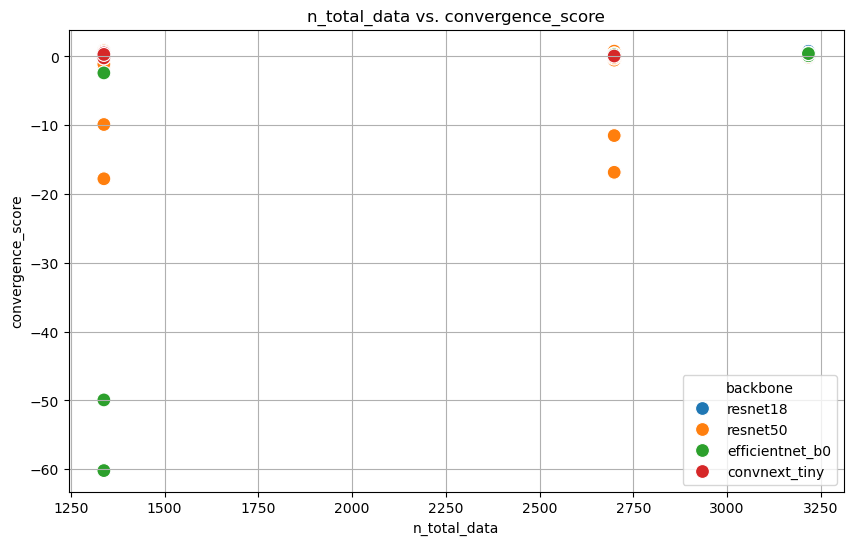

In [14]:
# this cell plots a dot for every run, with the x-axis being the value of the parameter of interest and the y-axis being the target metric
parameter_of_interest = "n_total_data" # "backbone" or "country_year_list" or "channels_to_use" or "n_total_data" or "pretrained" or "mlp_layers" or "dropout" or "lr" or "batch_size" or "num_epochs" or "test_size" or "random_state"
target_metric = "convergence_score" # or "convergence_score" or "test_improvement" or "test_volatility" or "overfit_gap" or "best_test_loss"

# filter out outliers automatically for axes limits by removing rows that are more than 3 standard deviations away
df = df[np.abs(df[target_metric] - df[target_metric].mean()) <= (3 * df[target_metric].std())]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=parameter_of_interest, y=target_metric, hue="backbone", s=100)
plt.title(f"{parameter_of_interest} vs. {target_metric}")
plt.grid(True)
plt.show()

/var/folders/40/7x1c6f516l7djcz4b8z3z4fr0000gn/T/ipykernel_27134/2473385470.py:9: FutureWarning: The provided callable <function mean at 0x107af37f0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df.pivot_table(index=parameter_of_interest_1, columns=parameter_of_interest_2, values=target_metric, aggfunc=np.mean)


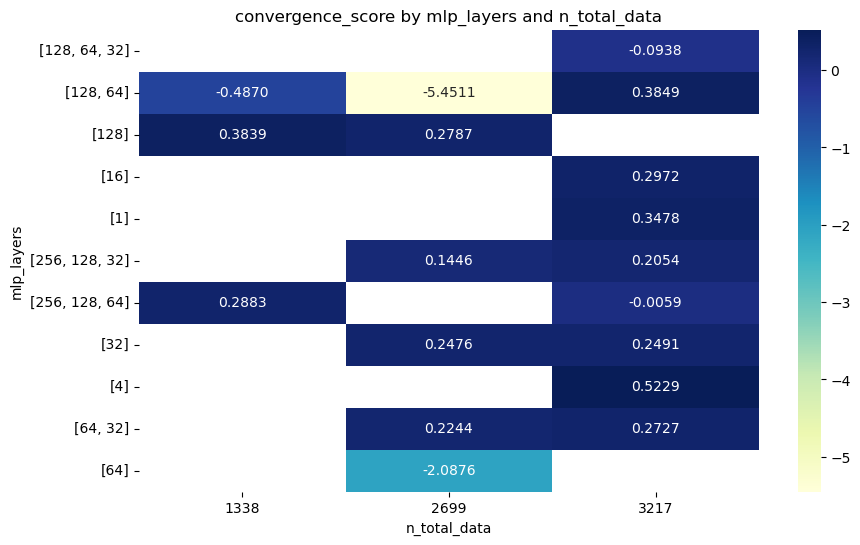

In [15]:
parameter_of_interest_1 = "mlp_layers" #  "backbone" or "country_year_list" or "channels_to_use" or "n_total_data" or "pretrained" or "mlp_layers" or "dropout" or "lr" or "batch_size" or "num_epochs" or "test_size" or "random_state"
parameter_of_interest_2 = "n_total_data"
target_metric = "convergence_score" # or "convergence_score" or "test_improvement" or "test_volatility" or "best_test_loss"

# filter out outliers automatically for axes limits by removing rows that are more than 3 standard deviations away
df = df[np.abs(df[target_metric] - df[target_metric].mean()) <= (3 * df[target_metric].std())]

# pivot and heatmap
pivot = df.pivot_table(index=parameter_of_interest_1, columns=parameter_of_interest_2, values=target_metric, aggfunc=np.mean)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title(f"{target_metric} by {parameter_of_interest_1} and {parameter_of_interest_2}")
plt.show()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Which metrics to show boxplots for:
METRICS_TO_PLOT = ["overfit_gap", "test_volatility", "best_test_loss", "convergence_score", "test_improvement"]

@interact(index=widgets.IntSlider(min=0, max=len(df)-1, step=1, value=0))
def explore_runs(index=0):
    """
    Interactively scroll through runs (rows in df).
    Left subplot: Train vs Test Loss progression
    Right subplots: Boxplots of each metric across df + a line for the current run's value
    Spines are removed, horizontal grid is on, and y-limits are clipped to whisker +/-10%.
    """
    row = df.iloc[index]

    # Access train/test losses
    train_losses = row["train_loss_progression"]
    test_losses  = row["test_loss_progression"]
    model_name   = row["model_name"]

    if not train_losses or not test_losses:
        print(f"Row {index} has no train/test progression data.")
        return
    
    # Prepare figure: one row, 1 + len(METRICS_TO_PLOT) subplots
    fig, axs = plt.subplots(
        1, 1 + len(METRICS_TO_PLOT), 
        figsize=(5 + 4*len(METRICS_TO_PLOT), 4), 
        tight_layout=True
    )

    if len(METRICS_TO_PLOT) == 0:
        # Edge case: no metrics
        axs = [axs]  # just unify the interface
    elif len(METRICS_TO_PLOT) == 1:
        # If there's only 1 metric, axs won't be iterable in the same way
        axs = [axs[0], axs[1]]  # unify into a list

    ax_loss = axs[0]

    # --- 1) Plot the train vs test loss in ax_loss ---
    num_epochs = len(train_losses)
    ax_loss.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    ax_loss.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    # set y range
    ax_loss.set_ylim(0, 0.05)
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("MSE Loss")
    ax_loss.set_title(f"Train vs. Test Loss\nModel={model_name}")
    ax_loss.grid(axis='y')
    ax_loss.legend()

    # --- 2) Boxplots for each metric in the remaining subplots ---
    for i, metric in enumerate(METRICS_TO_PLOT):
        ax_box = axs[i+1]
        val = row[metric]

        # Subset data for this metric (drop NaNs)
        col_data = df[metric].dropna()
        if len(col_data) == 0:
            ax_box.set_title(metric)
            ax_box.text(0.5, 0.5, "No data", ha='center', va='center')
            ax_box.set_xticks([])
            ax_box.set_yticks([])
            continue
        
        # Create a vertical boxplot
        sns.boxplot(
            y=col_data, 
            ax=ax_box,
            orient='v',
            color='skyblue',
            width=0.3
        )

        # Remove top/right spines
        sns.despine(ax=ax_box, top=True, right=True, left=True, bottom=True)
        # Add a horizontal grid
        ax_box.grid(axis='y', linestyle='--', alpha=0.7)

        # Title
        ax_box.set_title(metric, pad=10)
        ax_box.set_ylabel(None)

        # 2a) Compute whiskers => Q1 - 1.5*IQR, Q3 + 1.5*IQR
        q1 = np.percentile(col_data, 25)
        q3 = np.percentile(col_data, 75)
        iqr = q3 - q1
        whisker_min = q1 - 1.5 * iqr
        whisker_max = q3 + 1.5 * iqr

        # Expand 10% beyond whiskers
        rng = whisker_max - whisker_min
        pad = 0.1 * rng
        lower_lim = whisker_min - pad
        upper_lim = whisker_max + pad
        
        # In case whisker_min==whisker_max (all data identical), avoid zero range
        if rng <= 1e-8:
            lower_lim = whisker_min - 0.1
            upper_lim = whisker_max + 0.1

        ax_box.set_ylim(lower_lim, upper_lim)

        # 2b) Draw a horizontal line for the current run's metric value
        ax_box.axhline(val, color='red', linestyle='--', linewidth=2)
        # Annotate the line with the value
        ax_box.text(0.4, val, f"{val:.4f}", color='red', va='bottom', fontweight='bold')

        # Remove x ticks/labels because it's just one box
        ax_box.set_xticks([])


    plt.show()

    # --- 3) Print hyperparameters or other details ---
    print("\n----------- Hyperparameters / Info -----------")
    print(f"Row Index: {index}")
    print(f"Model Name: {row['model_name']}")
    print(f"Backbone: {row['backbone']}")
    print(f"Pretrained: {row['pretrained']}")
    print(f"MLP Layers: {row['mlp_layers']}")
    print(f"Dropout: {row['dropout']}")
    print(f"Freeze CNN Backbone: {row['freeze_cnn']}")
    print(f"Weight Decay: {row['weight_decay']}")
    print(f"LR: {row['lr']}")
    print(f"Batch Size: {row['batch_size']}")
    print(f"Num Epochs: {row['num_epochs']}")
    print(f"Best Test Loss: {row['best_test_loss']:.4f}")
    print(f"Convergence Score: {row['convergence_score']:.4f}")

interactive(children=(IntSlider(value=0, description='index', max=153), Output()), _dom_classes=('widget-inter…